In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
np.random.seed(4747)

## Introducing, A Fully-Connected NN Model to Predict Temperature-anomaly based off Latitude, Longitude, Elevation, Species, Year, and d18O.

In [3]:
# df = pd.read_csv('all_coral_with_ocean_anom.csv')
df = pd.read_csv('all_coral_with_temp_fixed_1880-2012.csv')
df = df.drop('Unnamed: 0.1', 1)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom
0,0,11.170000,119.150000,-4,Montastaea faveolata,1927,-4.067500,-0.405418
1,1,11.170000,119.150000,-4,Montastaea faveolata,1928,-3.865000,-0.503512
2,2,11.170000,119.150000,-4,Montastaea faveolata,1929,-3.865000,-0.819141
3,3,11.170000,119.150000,-4,Montastaea faveolata,1930,-4.007500,-0.337399
4,4,11.170000,119.150000,-4,Montastaea faveolata,1931,-4.040000,-0.099585
...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456


Fixing typos acquired from the original text scraping.

In [4]:
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Montastaea faveolata",
                 value ="Montastraea faveolata")
df = df.replace(to_replace ="Montastraea faviolata",
                 value ="Montastraea faveolata")         
df = df.replace(to_replace ="Porites australiensis",
                 value ="Porites australiensus") 
         

One-hot encoding of the species.

In [5]:
encoder_df = pd.get_dummies(df[['species']], prefix='species')
df = df.join(encoder_df)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0,11.170000,119.150000,-4,Montastraea faveolata,1927,-4.067500,-0.405418,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11.170000,119.150000,-4,Montastraea faveolata,1928,-3.865000,-0.503512,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,11.170000,119.150000,-4,Montastraea faveolata,1929,-3.865000,-0.819141,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,11.170000,119.150000,-4,Montastraea faveolata,1930,-4.007500,-0.337399,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,11.170000,119.150000,-4,Montastraea faveolata,1931,-4.040000,-0.099585,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579,0,0,...,0,0,0,0,0,1,0,0,0,0
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014,0,0,...,0,0,0,0,0,1,0,0,0,0
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223,0,0,...,0,0,0,0,0,1,0,0,0,0
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456,0,0,...,0,0,0,0,0,1,0,0,0,0


Now, we want to predict `temp`, given `species`, `year`, `d18O`, `lat`, and `long`.

First, let's configure all the data into one big dataframe. But only for years after 1960 (those are the temperature years we're pretty sure about). We will want to save the data with years before 1960 as part of our test data.

Then, let's scale everything between 1 and 0 to make it more suitable for the neural network.

In [6]:
cols_to_use = ['elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_1960 = df[df['year']<2021]
df_1960 = df_1960[df_1960['year']>1959]

df_1960 = df_1960.dropna() # this removes a TON of data.... we should find a way to not have remove all the NaNs and instead fill them with something
df_1960 = df_1960.reset_index()
df_1960 = df_1960.drop(columns = ['index'])
df_1960 

X = df_1960[cols_to_use]
Y = df_1960['temp_anom']

In [7]:
X = X.reset_index()
X = X.drop(columns = ['index'])
X 

,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,species_Montastraea faveolata,species_Orbicella faveolata,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,-4,-3.777500,1960,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-4,-4.152500,1961,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-4,-4.022500,1962,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-4,-3.672500,1963,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-4,-3.912500,1964,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,-5,-5.474000,2008,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2865,-5,-5.249917,2009,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2866,-5,-5.299417,2010,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2867,-5,-5.397417,2011,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
X = X[X['year'].notna()]
X = X[X['year']!='-999']
X = X[X['year']!='NAN']

X = X[X['elevation'].notna()]
X = X[X['elevation']!='-999']
X = X[X['elevation']!='NAN']
X['elevation'] = X['elevation'].apply(lambda x: x.strip('m'))

X['elevation'] = X['elevation'].apply(lambda x: float(x))
X['year'] = X['year'].apply(lambda x: float(x))

Scale all the input variables between -1 and 1.

In [9]:
from sklearn import preprocessing

ModuleNotFoundError: No module named 'sklearn'

In [244]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

cols = X.columns
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=cols)
X_scaled.head()


,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.300928,-0.406596,0.819549,-0.026103,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.300928,-0.406596,0.819549,-0.107760,-0.962264,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.300928,-0.406596,0.819549,-0.079452,-0.924528,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.300928,-0.406596,0.819549,-0.003239,-0.886792,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.300928,-0.406596,0.819549,-0.055500,-0.849057,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [126]:
Y = Y.reset_index()
Y = Y.drop(columns = ['index'])
Y 

,temp_anom
0,-0.284105
1,-0.504643
2,-0.531974
3,-0.755829
4,-0.417459
...,...
2864,0.210579
2865,0.288014
2866,0.664223
2867,0.425456


In [19]:
# from sklearn.model_selection import train_test_split
# X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(
#     X_scaled, Y, test_size=0.2, random_state=47)

In [128]:
# X_val_and_test.shape, Y_val_and_test.shape

In [127]:
# X_val_and_test.index, Y_val_and_test.index

In [130]:
# X_train.shape, Y_train.shape

In [171]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [172]:
from numpy.random import seed
seed(47)

## Sequential Neural Network

In [173]:
network = Sequential()

#input layer
network.add(Dense(8, input_shape=(23,), activation='LeakyReLU'))

#middle layers
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dropout(0.2))

network.add(Dense(6, activation='LeakyReLU'))

network.add(Dense(4, activation='LeakyReLU'))
network.add(Dropout(0.2))

#output layer
network.add(Dense(1, activation='LeakyReLU'))

network.compile('adam', loss='mse', metrics=['mse'])
#network.fit(X_train, Y_train, epochs=200)
network.fit(X_scaled, Y, epochs=50)

Epoch 1/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1312 - mse: 0.1312
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1236 - mse: 0.1236
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1183 - mse: 0.1183
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1162 - mse: 0.1162
Epoch 5/50
90/90 [==============================] - 0s 858us/step - loss: 0.1092 - mse: 0.1092
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1068 - mse: 0.1068
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1028 - mse: 0.1028
Epoch 8/50
90/90 [==============================] - 0s 851us/step - loss: 0.1013 - mse: 0.1013
Epoch 9/50
90/90 [==============================] - 0s 884us/step - loss: 0.0989 - mse: 0.0989
Epoch 10/50
90/90 [==============================] - 0s 849us/step - loss: 0.0988 - mse: 0.0988
Epoch 11/50
90/90 [==============================] - 0s 1ms/s

In [174]:
# network.evaluate(X_val_and_test, Y_val_and_test)

18/18 [==============================] - 0s 663us/step - loss: 0.0837 - mse: 0.0837


[0.08372066915035248, 0.08372066915035248]

This network with a dropout layer produces a teeny loss, maybe we're overfitting?

In [202]:
# actual = pd.DataFrame(Y_val_and_test, columns=["temp_anom"])
# predicted = pd.DataFrame(network.predict(X_val_and_test), columns=["pred"])
# actual.head(), predicted.head()

In [203]:
# predicted['index'] = actual.index
# predicted = predicted.set_index(['index'])
# predicted['index'] = actual.index
# predicted = predicted.set_index(['index'])
# predicted

In [204]:
# actual_v_pred = actual.join(predicted, how = "inner")
# actual_v_pred

In [205]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(Y_val_and_test, predicted)

In [206]:
# test_data_with_preds = actual_v_pred.join(X_val_and_test, how = "inner")
# test_data_with_preds['diff'] = test_data_with_preds['temp_anom'] - test_data_with_preds['pred']
# test_data_with_preds

In [207]:
# x = test_data_with_preds['temp_anom']
# y = test_data_with_preds['pred']
# plt.scatter(test_data_with_preds['temp_anom'], test_data_with_preds['pred'], color="pink")
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.xlim([-2, 1.5])
# plt.ylim([-2, 1.5])
# plt.title('Actual v. Predicted Gridded Temperature Anomaly')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

In [208]:
# x = test_data_with_preds['d18o']
# y = test_data_with_preds['diff']
# plt.scatter(test_data_with_preds['d18o'], test_data_with_preds['diff'], color="purple")
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.xlim([-1, 1])
# plt.ylim([-1.5, 1.5])
# plt.title('d18O v. Gridded Temperature Anomaly Error')
# plt.xlabel('d18O')
# plt.ylabel('Temp Error')

In [209]:
# plt.scatter(test_data_with_preds['lat'], test_data_with_preds['diff'])

In [210]:
# plt.scatter(test_data_with_preds['lon'], test_data_with_preds['diff'], color="orange")

Let's now take all of our predictions, average them by year

In [211]:
# test_data_with_preds.boxplot(column = ['pred', 'temp_anom'])

In [212]:
# annual_temp_and_preds = test_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
# annual_compare = annual_temp_and_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
# annual_compare.head()

In [213]:
# plt.plot(annual_compare['year'], annual_compare['temp_anom']), plt.plot(annual_compare['year'], annual_compare['pred'])

Sweet --- looks like we've at least followed the general trend of global warming :)

In [214]:
# np.corrcoef(annual_compare['temp_anom'], annual_compare['pred'])

In [215]:
# np.var(annual_compare['temp_anom']), np.var(annual_compare['pred'])

We should note that our predictions do not vary as much as the actual values.

In [216]:
# annual_compare.to_csv('preds_1960-2020.csv')

Let's see how our model performs on the years prior to 1960.

In [217]:
cols_to_use = ['elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_past = df[df['year']<1960]

df_past = df_past.dropna()
df_past = df_past.reset_index()
df_past = df_past.drop(columns = ['index'])
df_past 

X_past = df_past[cols_to_use]
Y_past = df_past['temp_anom']

In [218]:
X_past = X_past.reset_index()
X_past = X_past.drop(columns = ['index'])
X_past

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.17,119.15,-4,-4.067500,1927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.17,119.15,-4,-3.865000,1928,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.17,119.15,-4,-3.865000,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.17,119.15,-4,-4.007500,1930,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.17,119.15,-4,-4.040000,1931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,5.87,17.87,-10,-4.753333,1955,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4026,5.87,17.87,-10,-4.785000,1956,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4027,5.87,17.87,-10,-4.924167,1957,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4028,5.87,17.87,-10,-5.017500,1958,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [219]:
X_past = X_past[X_past['year'].notna()]
X_past = X_past[X_past['year']!='-999']
X_past = X_past[X_past['year']!='NAN']

X_past = X_past[X_past['elevation'].notna()]
X_past = X_past[X_past['elevation']!='-999']
X_past = X_past[X_past['elevation']!='NAN']
X_past['elevation'] = X_past['elevation'].apply(lambda x: x.strip('m'))

X_past['elevation'] = X_past['elevation'].apply(lambda x: float(x))
X_past['year'] = X_past['year'].apply(lambda x: float(x))

In [220]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

cols = X_past.columns
d = scaler.fit_transform(X_past)
X_past = pd.DataFrame(d, columns=cols)
X_past.head()

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.300928,-0.406596,0.819549,-0.445162,0.189873,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.300928,-0.406596,0.819549,-0.397605,0.215190,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.300928,-0.406596,0.819549,-0.397605,0.240506,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.300928,-0.406596,0.819549,-0.431071,0.265823,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.300928,-0.406596,0.819549,-0.438704,0.291139,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [221]:
Y_past = Y_past.reset_index()
Y_past = Y_past.drop(columns = ['index'])
Y_past 

,temp_anom
0,-0.405418
1,-0.503512
2,-0.819141
3,-0.337399
4,-0.099585
...,...
4025,-0.679975
4026,-0.700354
4027,-0.415288
4028,-0.047501


Use this functionality to convert `X_past` and `Y_past` from `nparrays` to `tensors`

In [222]:
actual_past = pd.DataFrame(Y_past, columns=["temp_anom"])
predicted_past = pd.DataFrame(network.predict(X_past), columns=["pred"])
actual_past.head(), predicted_past.head()

(   temp_anom
 0  -0.405418
 1  -0.503512
 2  -0.819141
 3  -0.337399
 4  -0.099585,
        pred
 0 -0.007055
 1 -0.000950
 2  0.008539
 3  0.016193
 4  0.025254)

In [223]:
network.evaluate(X_past, Y_past)

126/126 [==============================] - 0s 1ms/step - loss: 0.4693 - mse: 0.4693


[0.46934279799461365, 0.46934279799461365]

We have a much larger `test` loss than we did within the ranges of our training bounds. 

In [224]:
actual_v_pred_past = actual_past.join(predicted_past, how = "inner")
actual_v_pred_past

,temp_anom,pred
0,-0.405418,-0.007055
1,-0.503512,-0.000950
2,-0.819141,0.008539
3,-0.337399,0.016193
4,-0.099585,0.025254
...,...,...
4025,-0.679975,0.777254
4026,-0.700354,0.801943
4027,-0.415288,0.824702
4028,-0.047501,0.848284


In [225]:
past_data_with_preds = actual_v_pred_past.join(X_past, how = "inner")
past_data_with_preds['diff'] = actual_v_pred_past['temp_anom'] - actual_v_pred_past['pred']
past_data_with_preds

,temp_anom,pred,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,...,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni,diff
0,-0.405418,-0.007055,0.300928,-0.406596,0.819549,-0.445162,0.189873,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.398363
1,-0.503512,-0.000950,0.300928,-0.406596,0.819549,-0.397605,0.215190,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.502562
2,-0.819141,0.008539,0.300928,-0.406596,0.819549,-0.397605,0.240506,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.827680
3,-0.337399,0.016193,0.300928,-0.406596,0.819549,-0.431071,0.265823,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.353592
4,-0.099585,0.025254,0.300928,-0.406596,0.819549,-0.438704,0.291139,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.124839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,-0.679975,0.777254,0.126953,-0.999982,0.729323,-0.606231,0.898734,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.457229
4026,-0.700354,0.801943,0.126953,-0.999982,0.729323,-0.613668,0.924051,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.502298
4027,-0.415288,0.824702,0.126953,-0.999982,0.729323,-0.646352,0.949367,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.239990
4028,-0.047501,0.848284,0.126953,-0.999982,0.729323,-0.668271,0.974684,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.895785


([<matplotlib.lines.Line2D at 0x7fea40bd0bb0>],
 [<matplotlib.lines.Line2D at 0x7fea41879a30>])

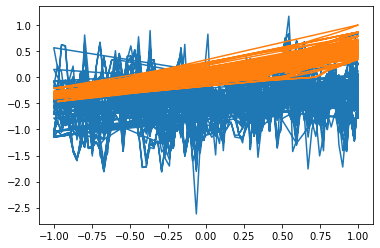

In [226]:
plt.plot(past_data_with_preds['year'], past_data_with_preds['temp_anom']), plt.plot(past_data_with_preds['year'], past_data_with_preds['pred'])

In [227]:
annual_temp_and_preds = past_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
annual_compare = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
annual_compare

<ipython-input-227-2651521bf6e3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()


,year,temp_anom,pred
0,-1.000000,-0.580696,-0.319498
1,-0.974684,-0.437284,-0.322879
2,-0.949367,-0.448660,-0.311360
3,-0.924051,-0.535872,-0.312129
4,-0.898734,-0.577859,-0.296652
...,...,...,...
75,0.898734,-0.628892,0.479466
76,0.924051,-0.655931,0.500699
77,0.949367,-0.272213,0.523098
78,0.974684,-0.251039,0.544479


([<matplotlib.lines.Line2D at 0x7fea409758e0>],
 [<matplotlib.lines.Line2D at 0x7fea4095a8b0>])

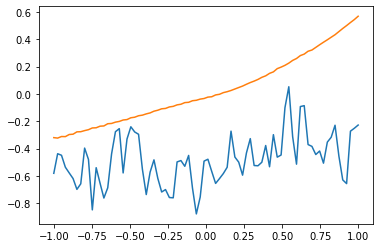

In [228]:
plt.plot(annual_compare['year'], annual_compare['temp_anom']), plt.plot(annual_compare['year'], annual_compare['pred'])

Our network very much over-predicted the `temp_anom`. Probalby because it over-fit to the traiign data which had higher temp anomalies.

In [234]:
annual_compare['year'] = np.arange(1880, 1960, 1)
annual_compare

,year,temp_anom,pred
0,1880,-0.580696,-0.319498
1,1881,-0.437284,-0.322879
2,1882,-0.448660,-0.311360
3,1883,-0.535872,-0.312129
4,1884,-0.577859,-0.296652
...,...,...,...
75,1955,-0.628892,0.479466
76,1956,-0.655931,0.500699
77,1957,-0.272213,0.523098
78,1958,-0.251039,0.544479


In [236]:
annual_compare.to_csv('compare_1880-1960.csv')